**RANSAC algorithm applied to LIDAR data extracted from ROS2 simulations**

*Authors: Michele Sandrini, Fabio Castellini*

*A.Y. 2021-2022 at UNIVR*


In [59]:
import numpy as np
from random import randint
from matplotlib.pyplot import figure
import json
import numpy
import matplotlib.pyplot as plt
from google.colab import files

def ransac(threshold, iterations, distancesForRansac, anglesForRansac, add_noise=False, sigma=0.001):

    #Retrieve cartesian coordinates from polar lidar scansions (angle is given by the index + the "front_angle_half") 
    lidar_cart = [pol2cart(distance, anglesForRansac[k]) for k, distance in enumerate(distancesForRansac)]

    lidar_cart_x = [coord[0] for coord in lidar_cart] # x coordinates
    lidar_cart_y = [coord[1] for coord in lidar_cart] # y coordinates

    #Add noise 
    if add_noise:
        mu = 0 # mean and standard deviation "sigma" of the white noise 
        lidar_cart_noise = [ tuple(lidar_cart_xy + np.random.normal(mu,sigma,2)) for lidar_cart_xy in lidar_cart ]
        lidar_cart_noise_x = [coord[0] for coord in lidar_cart_noise] 
        lidar_cart_noise_y = [coord[1] for coord in lidar_cart_noise]

        X = lidar_cart_noise_x
        y = lidar_cart_noise_y

    else:
        X = lidar_cart_x
        y = lidar_cart_y

    # Memorize the consensus and the "(m, q)" parameters associated to each model
    consensus = np.zeros([iterations])
    parameters = np.zeros([iterations,2]) #(m,q)

    n_samples = len(X) # number of points

    for i in range(iterations):
        
        index1 = randint(0, n_samples-1)
        point1 = X[index1], y[index1] # Retrieve a random tuple (x,y)
        
        index2 = randint(0, n_samples-1)
        while (index2 == index1):
            index2 = randint(0, n_samples-1)  # To have a different point than point1

        point2 = X[index2], y[index2]         # Prelevo un'altra coppia random (x,y)
        
        # Create the estimated model that represents a line (only having 2 params: angular "m" and translation "q" coefficients )
        if point2[0]-point1[0] > 0.001:  #to "handle" division by zero
            m_estimate = (point2[1]-point1[1]) / (point2[0]-point1[0])
        else:
            m_estimate = 10 # to saturate angular coefficient (remember that lines parallel to y axis has infinite ang. coeff.)
        q_estimate = -m_estimate*point1[0] + point1[1]  #y = mx + q --> q = -mx + y
      
        parameters[i,:] = m_estimate, q_estimate

        # Compute consensus for each model
        for k in range(n_samples):
            # If the distance between point and line is lower than threshold consesus is increased
            y_coord = y[k]
            x_coord = X[k] 

            m_estimate = parameters[i,0]
            q_estimate = parameters[i,1]

            if abs( y_coord - (m_estimate*x_coord + q_estimate) ) < threshold:
                consensus[i] += 1

    # Extract the highest consensus model
    for ind in range(len(consensus)):
        if(max(consensus) == consensus[ind]):
            m_best, q_best = parameters[ind,0], parameters[ind,1]

    # Retrieve inlier and outlier points
    inliers  = np.empty([1,2])  # initialization
    outliers = np.empty([1,2])  # initialization

    for n in range(n_samples):
        y_coord = y[n] 
        x_coord = X[n] 

        if abs( (y_coord - (m_best*x_coord + q_best)) ) < threshold: # inliers point
            inliers = np.vstack([inliers, [x_coord, y_coord]])
        else:
            outliers = np.vstack([outliers, [x_coord, y_coord]])     # outlier point

    inliers = inliers[1:]   # remove first element due to initialization
    outliers = outliers[1:] # remove first element due to initialization

    return inliers, outliers, m_best, q_best, [cart2pol(X[k], y[k]) for k in range(len(X))]


def draw_line(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--', label="Line using m_best, q_best")

def plot_ransac_results(inliers, outliers, m_best, q_best, fig_title):
    figure(figsize=(16, 4), dpi=300)

    # Compare estimated coefficients
    print("MY RANSAC (m_best, q_best):", m_best, q_best)

    lw = 2
    plt.scatter(inliers[:,0], inliers[:,1], color="yellowgreen", marker=".", label="Inliers") # scatter inliers
    plt.scatter(outliers[:,0], outliers[:,1], color="gold", marker=".", label="Outliers")     # scatter outliers

    draw_line(m_best, q_best) # draw the fitted line given "m" and "q" parameters

    #fit the line only on the inliers
    m_fitted, q_fitted = np.polyfit(inliers[:,0], inliers[:,1], 1)
    print("Refitting on inliers: (m_fitted, q_fitted):", m_fitted, q_fitted)

    #add line of best fit to plot
    plt.plot(inliers[:,0], m_fitted*inliers[:,0]+q_fitted,  label="Line refitting (polyfit) only on inlier points")

    plt.legend(loc="lower right")
    plt.xlabel("Input")
    plt.ylabel("Response")
    
    plt.savefig(fig_title, dpi=300)
    files.download(fig_title) 
    plt.show()

def pol2cart(distance, angle):  #angle is expressed in degrees
    x = distance * np.cos(np.radians(angle))
    y = distance * np.sin(np.radians(angle))
    return (x, y)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

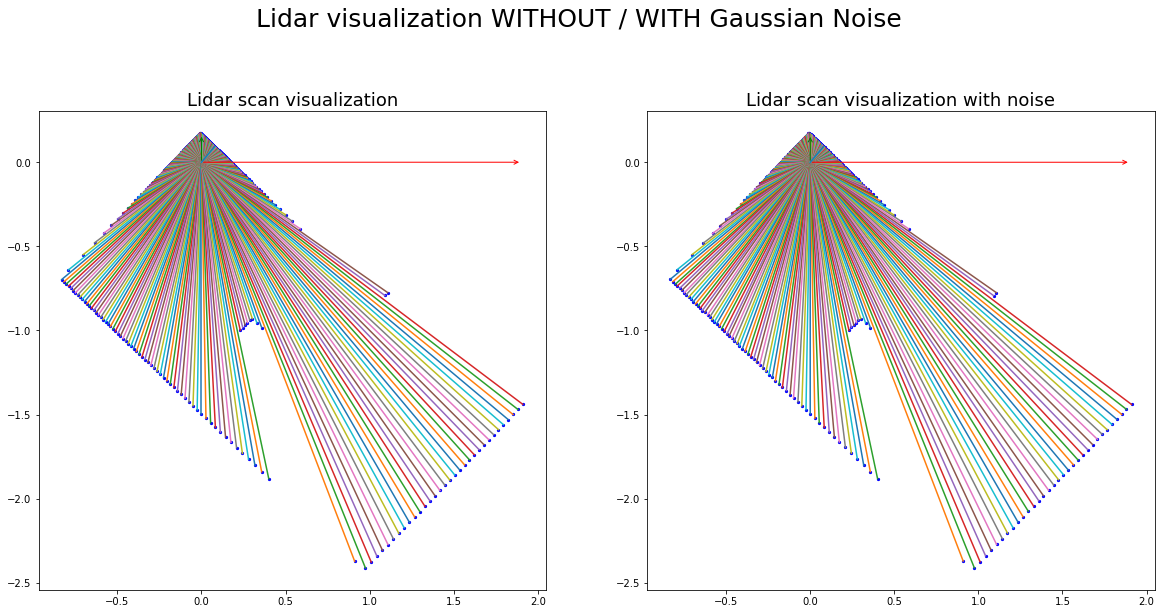

In [60]:
# Load .json files with LIDAR readings (from the simulation)

#file_lidar_readings = "lidarReadings_WALL_AT_LEFT.json"
#file_lidar_readings = "lidarReadings_MAP_CENTER.json"
#file_lidar_readings = "lidarReadings_WALL_CORRIDOR.json"
file_lidar_readings = "lidarReadings_CORNER_FRONT.json"

show_info = False

with open(file_lidar_readings,'r') as f:
    lidar_polar = json.load(f)

front_angle_half = 50 
side_angle = 85 # angle width of regions 'left' and 'right' in degrees

#lidar_left_polar = lidar_polar[front_angle_half:front_angle_half+side_angle]  #only values in range [front_angle_half:front_angle_half+side_angle]
lidar_left_polar = lidar_polar  #take all the 360 values

#Retrieve cartesian coordinates from polar lidar scansions (angle is given by the index + the "front_angle_half")
lidar_cart = [pol2cart(distance, front_angle_half + angle) for angle, distance in enumerate(lidar_left_polar)]
if show_info:
    print("Lidar cartesian coordaintes")
    print(lidar_cart)

#Visualize lidar readings
lidar_cart_x = [coord[0] for coord in lidar_cart]
lidar_cart_y = [coord[1] for coord in lidar_cart]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle('Lidar visualization WITHOUT / WITH Gaussian Noise', fontsize=25)

origin = [0,0]
for i in range(len(lidar_cart_x)):
    x_values = [origin[0], lidar_cart_x[i]]
    y_values = [origin[1], lidar_cart_y[i]]
    ax1.plot(x_values, y_values)
    ax1.scatter(x_values, y_values, s=5, c='b', marker='o')

ax1.annotate("", xy=(0.0, max(lidar_cart_y)-0.01), xytext=(0.0, 0.0), arrowprops=dict(arrowstyle="->", color='green'))
ax1.annotate("", xy=(max(lidar_cart_x)-0.01, 0.0), xytext=(0.0, 0.0), arrowprops=dict(arrowstyle="->", color='red'))
ax1.set_title('Lidar scan visualization', fontsize=18)
ax1.set_aspect('equal', 'box')


#Add noise
mu, sigma = 0, 0.001 # mean and standard deviation
lidar_cart_noise = [ tuple(lidar_cart_xy + np.random.normal(mu,sigma,2)) for lidar_cart_xy in lidar_cart]

if show_info:
    print("Lidar cartesian coordaintes with NOISE")
    print( lidar_cart_noise )

lidar_cart_noise_x = [coord[0] for coord in lidar_cart_noise]
lidar_cart_noise_y = [coord[1] for coord in lidar_cart_noise]

origin = [0,0]
for i in range(len(lidar_cart_x)):
    x_values = [origin[0], lidar_cart_noise_x[i]]
    y_values = [origin[1], lidar_cart_noise_y[i]]
    ax2.plot(x_values, y_values)
    ax2.scatter(x_values, y_values, s=5, c='b', marker='o')
    
ax2.annotate("", xy=(0.0, max(lidar_cart_noise_y)-0.01), xytext=(0.0, 0.0), arrowprops=dict(arrowstyle="->", color='green'))
ax2.annotate("", xy=(max(lidar_cart_noise_x)-0.01, 0.0), xytext=(0.0, 0.0), arrowprops=dict(arrowstyle="->", color='red'))
ax2.set_title('Lidar scan visualization with noise', fontsize=18)
ax2.set_aspect('equal', 'box')

plt.savefig(file_lidar_readings+'.png', dpi=300)
files.download(file_lidar_readings+'.png') 
plt.show()

-----------------------
First RANSAC iteration, found 111 inliers and 39 outliers
Second RANSAC iteration, found 39 inliers and 0 outliers
-----------------------

MY RANSAC (m_best, q_best): 0.9837161194030859 0.17382411777457235
Refitting on inliers: (m_fitted, q_fitted): 1.0305303305469344 0.1808772270501642


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

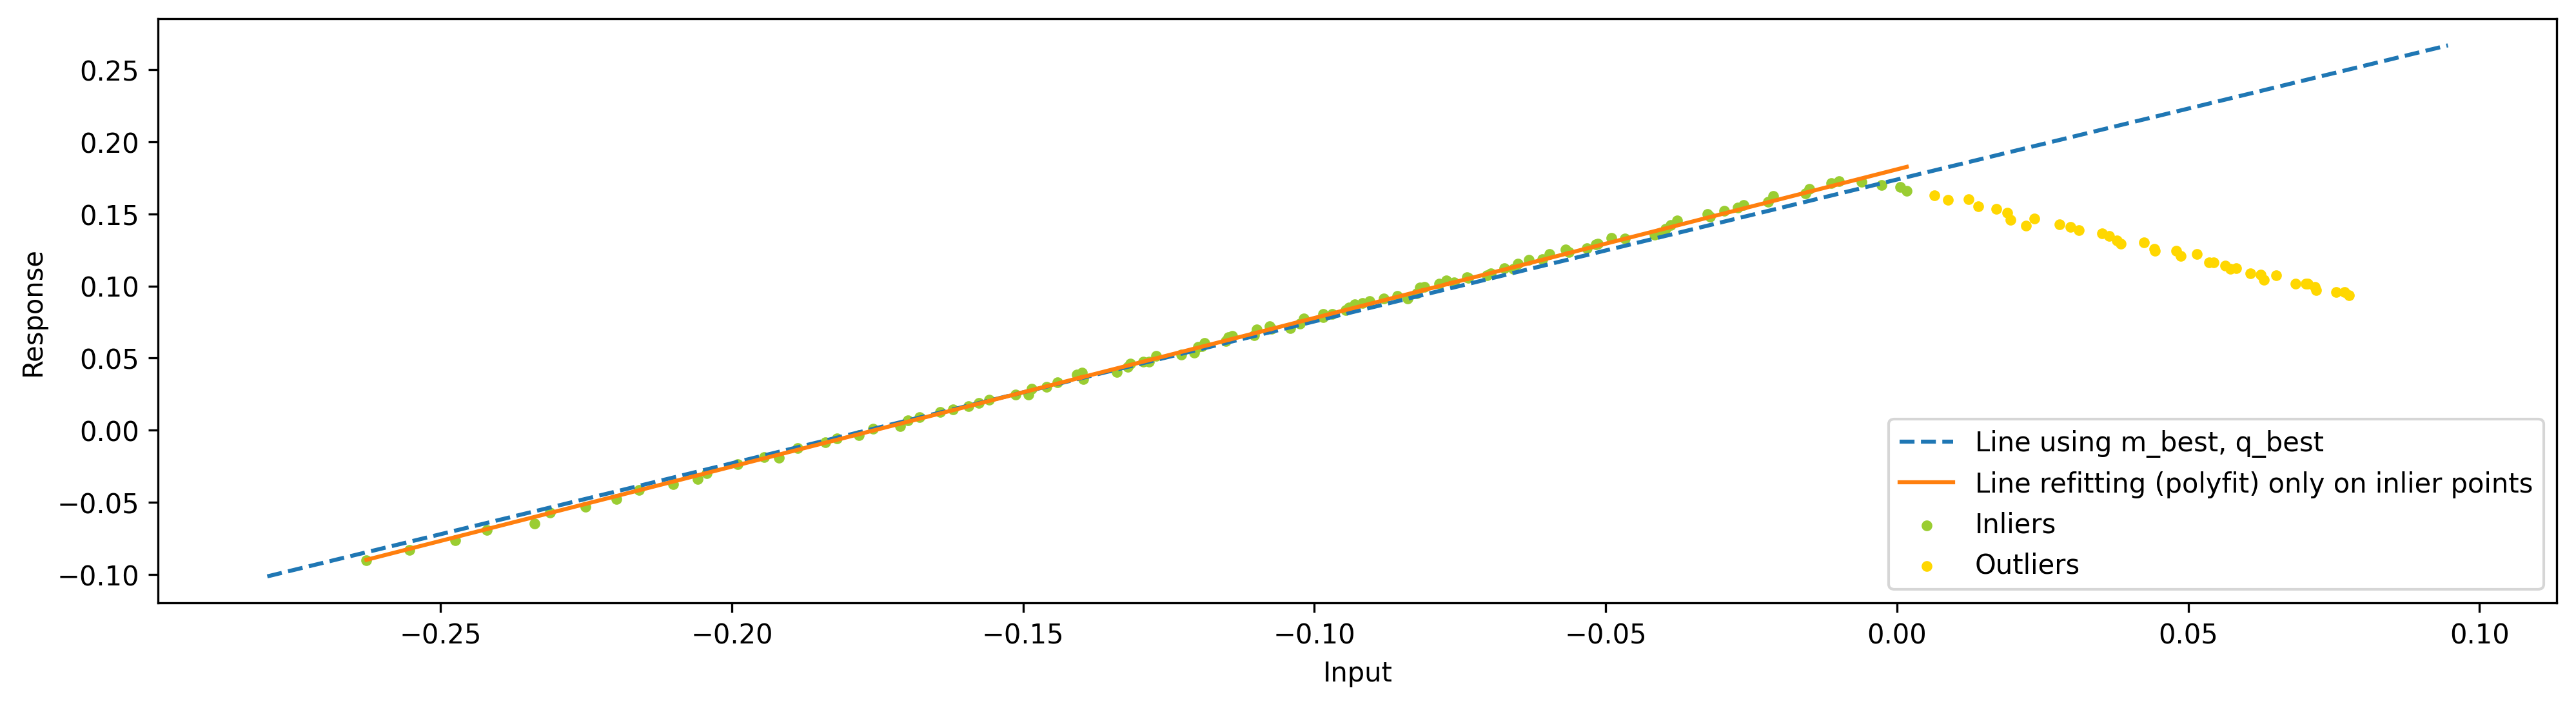

MY RANSAC (m_best, q_best): -0.8610412573494641 0.16284493047463078
Refitting on inliers: (m_fitted, q_fitted): -0.9696238377130535 0.16879339859881298


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

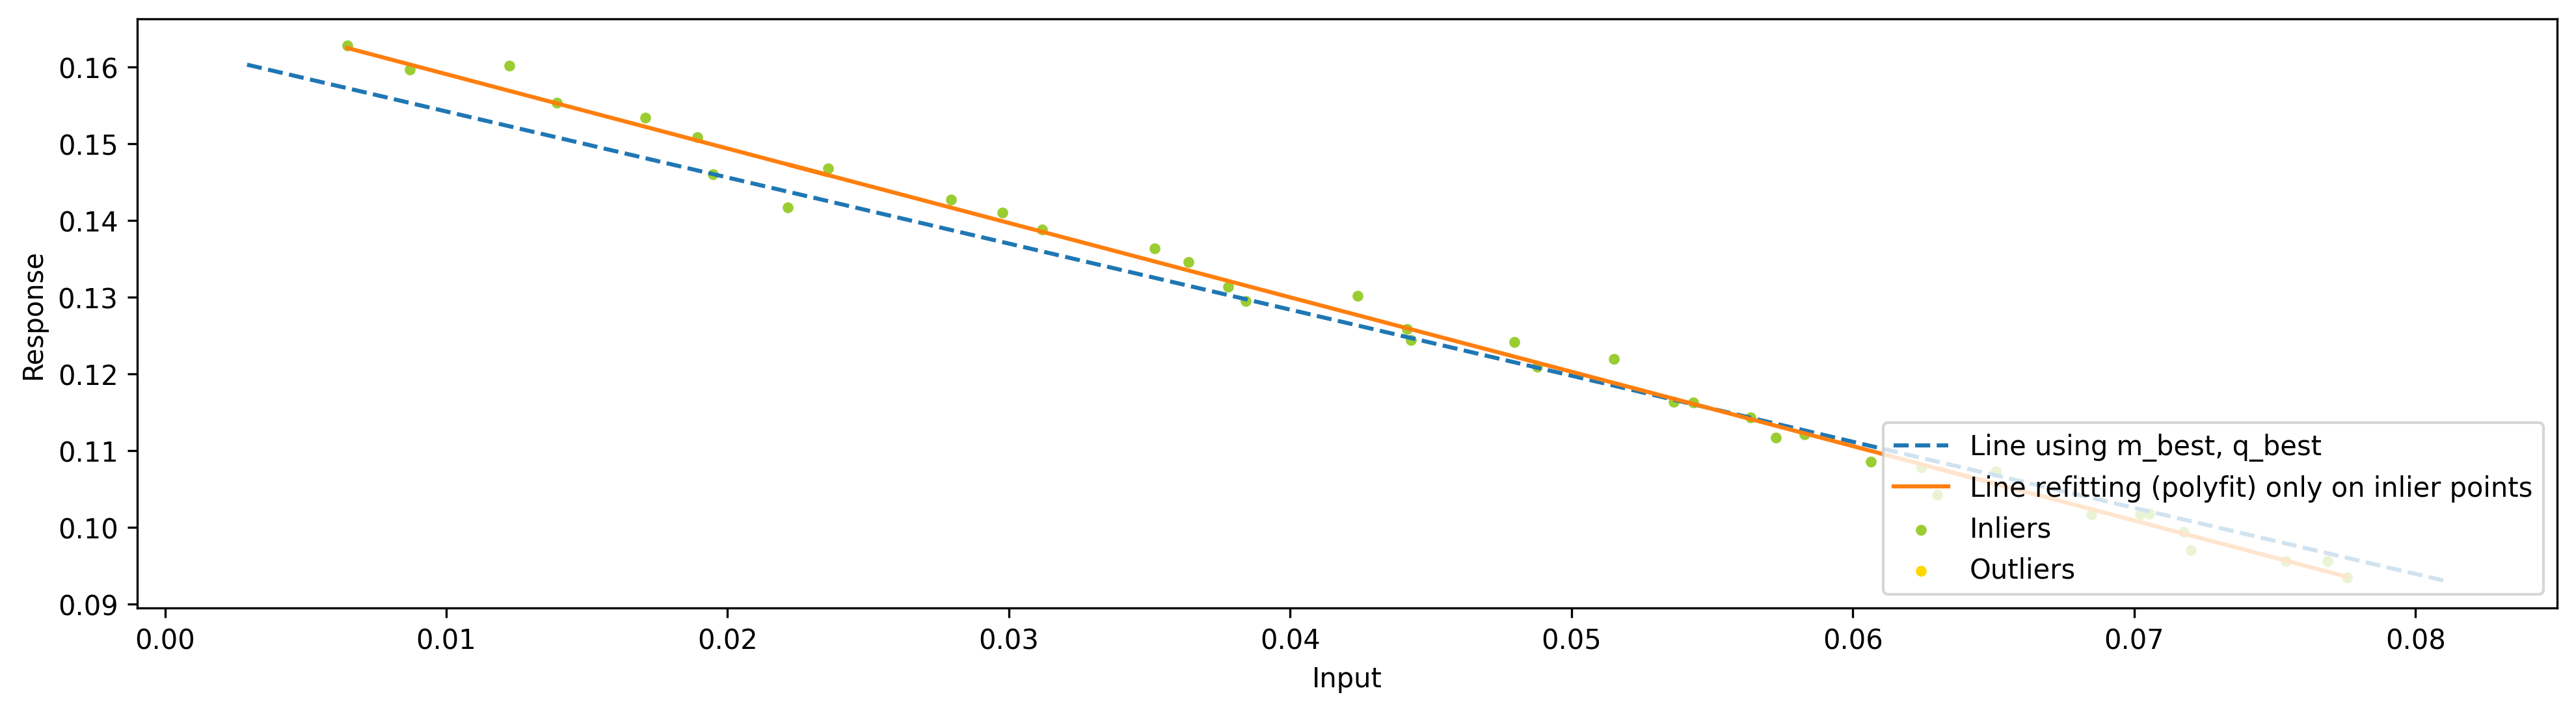

In [61]:
# Function that runs RANSAC 2 times, in order to handle corners. In our ROS2
# implementation won't be used because the first line is considered to be the 
# best, having more inliers.
def my_ransac_multiline(threshold, iterations, x, y):
    print("-----------------------")

    # Compute the first candidate model and retrieve inliers, outliers
    inliers_1, outliers_1, m_best_1, q_best_1 = my_ransac(threshold, iterations, x, y) 
    print("First RANSAC iteration, found",len(inliers_1),"inliers and",len(outliers_1),"outliers")

    if len(outliers_1) > 0.2*len(inliers_1):
        # Compute the second candidate model giving as points the outliers of the first iteration
        inliers_2, outliers_2, m_best_2, q_best_2 = my_ransac(threshold, iterations, outliers_1[:,0], outliers_1[:,1])
        print("Second RANSAC iteration, found",len(inliers_2),"inliers and",len(outliers_2),"outliers")
 
    else:
        print("Second RANSAC iteration, no inliers found (1 line problem)")
        inliers_2, outliers_2, m_best_2, q_best_2 = [], [], [], []

    print("-----------------------\n")
    return inliers_1, outliers_1, m_best_1, q_best_1, inliers_2, outliers_2, m_best_2, q_best_2

# Parameters of RANSAC
threshold = 0.01;
iterations = 1000;

x = np.array(lidar_cart_noise_x[0:150]) # choose a range of points onto which apllying RANSAC
y = np.array(lidar_cart_noise_y[0:150]) # choose a range of points onto which apllying RANSAC

inliers_1, outliers_1, m_best_1, q_best_1, inliers_2, outliers_2, m_best_2, q_best_2 = my_ransac_multiline(threshold, iterations, x, y)
plot_ransac_results(inliers_1, outliers_1, m_best_1, q_best_1, 'Multiline_plot1.png')     

if len(inliers_2) != 0:
    plot_ransac_results(inliers_2, outliers_2, m_best_2, q_best_2, 'Multiline_plot2.png')    
